In [1]:
import sys
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys-dmm/')
from utils.aux_funcs import flatten_series
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils.population import Population

In [2]:
import matplotlib.patches as patches
from matplotlib import cm

In [3]:
savepath = '/home/niell_lab/data/freely_moving_ephys/batch_files/120221_hffm/'

In [4]:
pop = Population(savepath)

In [5]:
pop.load_from_pickle(stage='population')

reading data from /home/niell_lab/data/freely_moving_ephys/batch_files/120221_hffm/pooled_ephys_population_update_120621.pickle


In [6]:
unit = pop.data.iloc[87] # 591; 281

In [7]:
possible_SbCs = [24, 30, 31, 32, 33, 37, 61, 68, 69, 88, 89, 91, 93, 104, 106, 123, 124, 126, 130, 137, 141, 142, 146, 147, 152, 155, 156, 158, 161, 162, 169, 170, 180, 184, 203, 226, 238, 265, 279, 280, 282, 296, 297, 308, 323, 329, 343, 346, 350, 358, 360, 363, 367, 393, 401, 419, 422, 438, 445, 449, 451, 453, 461, 481, 490, 503, 507, 516, 531, 540, 556, 558, 572, 590, 592, 612, 624, 636, 648, 660, 661]
possible_SbCs = np.array([i-1 for i in possible_SbCs])

In [149]:
lower = -0.5; upper = 1.5; dt = 0.1
bins = np.arange(lower,upper+dt,dt)
grat_x = bins[0:-1]+ dt/2
for ind, row in pop.data.iterrows():
    if row['hf1_wn_crf_tuning'][0]<1:
        pop.data.at[ind, 'SbC_type'] = np.nan
        continue
    high_contrast_std = np.std(row['hf1_wn_crf_tuning'][3:])
    pop.data.at[ind, 'high_contrast_std'] = high_contrast_std
    min_contrast = row['hf1_wn_crf_tuning'][0]
    mid_contrast = row['hf1_wn_crf_tuning'][3]
    max_contrast = row['hf1_wn_crf_tuning'][-1]
    min_mid_mod = (min_contrast - mid_contrast) / (min_contrast + mid_contrast)
    min_max_mod = (min_contrast - max_contrast) / (min_contrast + max_contrast)
    pop.data.at[ind, 'SbC_min_mid_mod'] = min_mid_mod
    pop.data.at[ind, 'SbC_min_max_mod'] = min_max_mod
    grat_psth_during_stim = row['hf3_gratings_grating_psth'][(grat_x<1) * (grat_x>0)]
    grat_psth_drop = (np.nanmean(grat_psth_during_stim) - row['hf3_gratings_rec_rate']) / row['hf3_gratings_rec_rate']
    pop.data.at[ind, 'grat_psth_drop'] = grat_psth_drop
    if (min_mid_mod>0.25 and grat_psth_drop<0):
        savetype = 'exp'
    elif (min_max_mod>0.25 and grat_psth_drop<0):
        savetype = 'vip'
    else:
        savetype = 'not_SbC'
    pop.data.at[ind, 'SbC_type'] = savetype

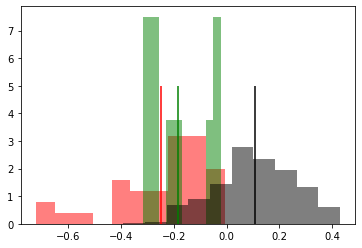

In [150]:
plt.hist(pop.data['grat_psth_drop'][pop.data['SbC_type']=='exp'], density=True, color='r', alpha=0.5)
plt.hist(pop.data['grat_psth_drop'][pop.data['SbC_type']=='vip'], density=True, color='g', alpha=0.5)
plt.hist(pop.data['grat_psth_drop'][pop.data['SbC_type']=='not_SbC'], density=True, color='k', alpha=0.5)
plt.vlines(pop.data['grat_psth_drop'][pop.data['SbC_type']=='exp'].mean(), 0, 5, color='r')
plt.vlines(pop.data['grat_psth_drop'][pop.data['SbC_type']=='vip'].mean(), 0, 5, color='g')
plt.vlines(pop.data['grat_psth_drop'][pop.data['SbC_type']=='not_SbC'].mean(), 0, 5, color='k')

In [151]:
row = pop.data.iloc[0]

In [152]:
grat_psth_during_stim = row['hf3_gratings_grating_psth'][(grat_x<1) * (grat_x>0)]
grat_psth_during_stim

array([1.22580645, 1.22580645, 1.21290323, 0.72258065, 0.86451613,
       0.82580645, 0.89032258, 0.76129032, 0.64516129, 1.00645161])

In [103]:
list(pop.data['SbC_type'].value_counts().keys())

['not_SbC', 'exp', 'vip']

Text(0.5, 0, 'mean gratings PSTH - gratings mean firing rate')

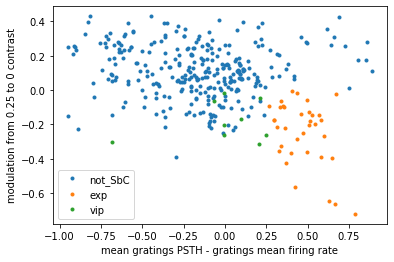

In [154]:
fig, ax = plt.subplots()
types = list(pop.data['SbC_type'].value_counts().keys())
for count, SbCtype in enumerate(types):
    plt.plot(pop.data['SbC_min_mid_mod'][pop.data['SbC_type']==SbCtype], pop.data['grat_psth_drop'][pop.data['SbC_type']==SbCtype], '.', color=cm.tab10(count))
plt.legend(types)
plt.ylabel('modulation from 0.25 to 0 contrast')
plt.xlabel('mean gratings PSTH - gratings mean firing rate')
# rect = patches.Rectangle((0, 0.25), 1, 0.75, linewidth=1, edgecolor='none', facecolor='y', alpha=0.1)
# ax.add_patch(rect)
# plt.xlim([0,3.5])
# plt.ylim([-1,1])

[Text(0, 0, 'not_SbC'), Text(1, 0, 'exp'), Text(2, 0, 'vip')]

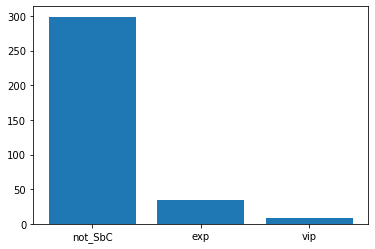

In [155]:
fig, ax = plt.subplots()
plt.bar(range(3), pop.data['SbC_type'].value_counts())
ax.set_xticks(range(3))
ax.set_xticklabels(types)

In [171]:
pop.data['SbC_type'].value_counts()/len(pop.data)

not_SbC    0.449624
exp        0.052632
vip        0.013534
Name: SbC_type, dtype: float64

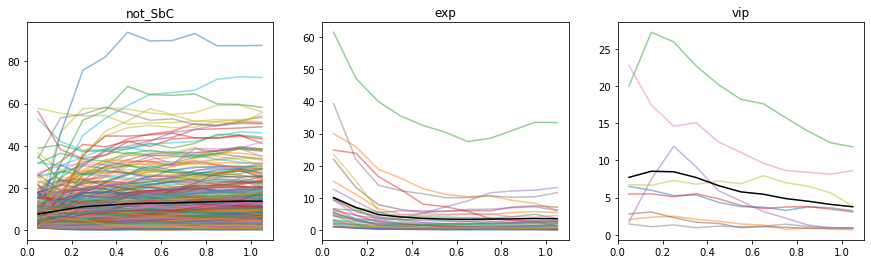

In [156]:
plt.subplots(1,3,figsize=(15,4))
for count, ctype in enumerate(types):
    plt.subplot(1,3,count+1)
    for ind, row in pop.data[pop.data['SbC_type']==ctype].iterrows():
        plt.plot(row['hf1_wn_crf_cent'], row['hf1_wn_crf_tuning'], alpha=0.5)
    plt.plot(row['hf1_wn_crf_cent'], np.mean(flatten_series(pop.data['hf1_wn_crf_tuning'][pop.data['SbC_type']==ctype]),0),'k')
    plt.title(ctype)

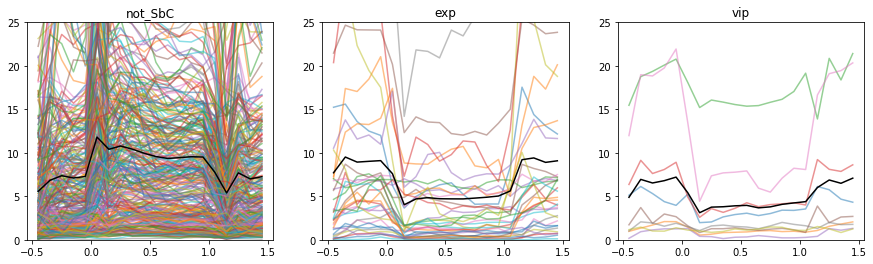

In [157]:
lower = -0.5; upper = 1.5; dt = 0.1
bins = np.arange(lower,upper+dt,dt)
grat_x = bins[0:-1]+dt/2
plt.subplots(1,3,figsize=(15,4))
for count, ctype in enumerate(types):
    plt.subplot(1,3,count+1)
    for i, psth in pop.data['hf3_gratings_grating_psth'][pop.data['SbC_type']==ctype].iteritems():
        plt.plot(grat_x, psth, alpha=0.5)
    plt.plot(grat_x, np.mean(flatten_series(pop.data['hf3_gratings_grating_psth'][pop.data['SbC_type']==ctype]),0), 'k')
    plt.title(ctype)
    plt.ylim([0,25])

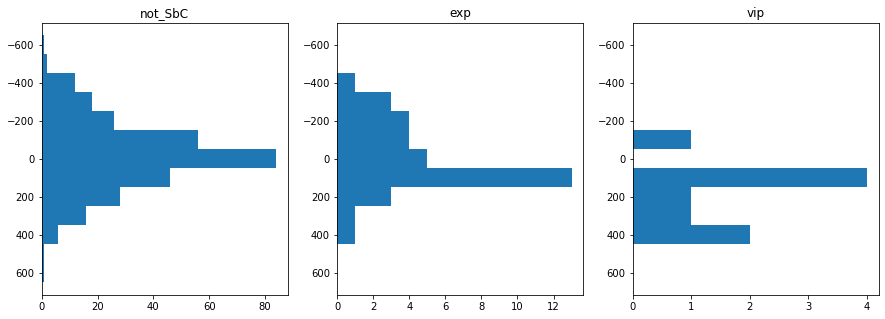

In [158]:
plt.subplots(1,3,figsize=(15,5))
for count, ctype in enumerate(types):
    plt.subplot(1,3,count+1)
    plt.hist(pop.data['hf1_wn_depth_from_layer5'][pop.data['SbC_type']==ctype],
         bins=list(np.arange(-650,650+100,100)), orientation='horizontal')
    plt.gca().invert_yaxis()
    plt.title(ctype)

In [159]:
exp_occ = pop.data['movement_psth_type_simple'][pop.data['SbC_type']=='exp'].value_counts()
vip_occ = pop.data['movement_psth_type_simple'][pop.data['SbC_type']=='vip'].value_counts()
nonsbc_occ = pop.data['movement_psth_type_simple'][pop.data['SbC_type']=='not_SbC'].value_counts()

Text(0, 0.5, 'fraction of cells')

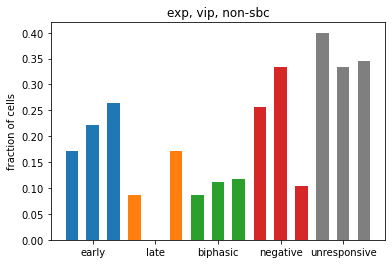

In [169]:
names = ['early','late','biphasic','negative','unresponsive']
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:gray']
for count, name in enumerate(names):
    k = colors[count]
    if name in exp_occ:
        plt.bar(count-0.33, exp_occ[name]/exp_occ.sum(), width=0.2, color=k)
    if name in vip_occ:
        plt.bar(count, vip_occ[name]/vip_occ.sum(), width=0.2, color=k)
    if name in nonsbc_occ:
        plt.bar(count+0.33, nonsbc_occ[name]/nonsbc_occ.sum(), width=0.2, color=k)
plt.xticks(ticks=range(5), labels=names)
plt.title('exp, vip, non-sbc')
plt.ylabel('fraction of cells')

Text(0, 0.5, 'fraction of cells')

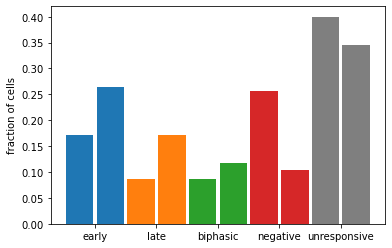

In [174]:
names = ['early','late','biphasic','negative','unresponsive']
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:gray']
for count, name in enumerate(names):
    k = colors[count]
    if name in exp_occ:
        plt.bar(count-0.25, exp_occ[name]/exp_occ.sum(), width=0.45, color=k)
    if name in nonsbc_occ:
        plt.bar(count+0.25, nonsbc_occ[name]/nonsbc_occ.sum(), width=0.45, color=k)
plt.xticks(ticks=range(5), labels=names)
plt.ylabel('fraction of cells')

In [183]:
pop.data['SbC_type'].value_counts()

not_SbC    299
exp         35
vip          9
Name: SbC_type, dtype: int64

In [180]:
exc_gratspd = pop.data['grat_speed_dps'][pop.data['SbC_type']=='exp']
other_gratspd = pop.data['grat_speed_dps'][pop.data['SbC_type']=='not_SbC']

Text(0, 0.5, 'speed (deg/sec)')

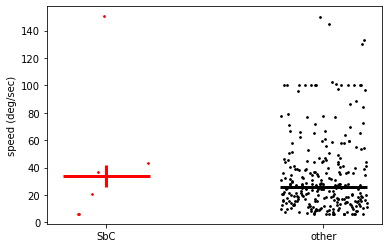

In [182]:
# problem here is that most SbC cells are not responsive to gratings...
# so looking at their speed tuning might require a different definition of 'response'
# don't remember how I'm defining 'responsive to gratings' at the moment
# but we could write something to see how muhc firing goes down in response
# to onset of stimulus instead of how much it goes up
psth_colors = ['r','k']
keys = ['SbC', 'other']
fig, ax = plt.subplots()
for count, spd_prefs in enumerate([exc_gratspd, other_gratspd]):
    mean = np.nanmedian(spd_prefs,0)
    stderr = np.nanstd(spd_prefs) / np.sqrt(np.size(spd_prefs,0))
    lbound = count-0.2; ubound = count+0.2
    x_jitter = np.random.uniform(lbound, ubound, np.size(spd_prefs,0))
    plt.scatter(x_jitter, spd_prefs, s=3, color=psth_colors[count])
    plt.hlines(mean, lbound, ubound, linewidth=3, color=psth_colors[count])
    plt.vlines(count, mean-stderr, mean+stderr, linewidth=3, color=psth_colors[count])
ax.set_xticks(range(len(keys)))
ax.set_xticklabels(keys)
ax.set_ylabel('speed (deg/sec)')

In [9]:
all_crf = flatten_series(pop.data['hf1_wn_crf_tuning'])
all_grat_psth = flatten_series(pop.data['hf3_gratings_grating_psth'])

In [10]:
all_norm_crf = np.divide(all_crf, np.nanmax(all_crf,0))
all_norm_grat_psth = np.divide(all_grat_psth, np.nanmax(all_grat_psth,0))

In [11]:
SbC_kmeans_input = np.concatenate([all_norm_crf, all_norm_grat_psth], 1)

In [12]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

In [13]:
reduced_data = PCA(n_components=3).fit_transform(SbC_kmeans_input)

In [14]:
np.shape(reduced_data)

(665, 3)

In [15]:
maybe_SbCs = reduced_data[possible_SbCs,:]

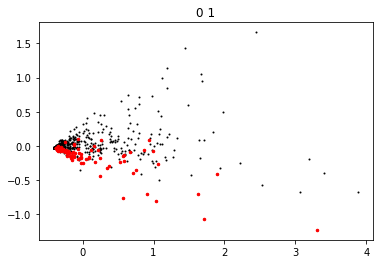

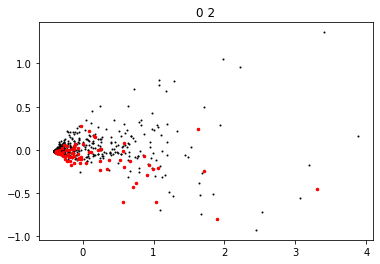

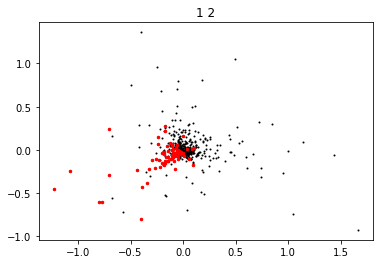

In [16]:
for x in [[0,1],[0,2],[1,2]]:
    i = x[0]; j = x[1]
    plt.figure()
    plt.title(str(i)+' '+str(j))
    plt.plot(reduced_data[:,i], reduced_data[:,j], 'k.', markersize=2)
    plt.plot(maybe_SbCs[:,i], maybe_SbCs[:,j], 'r.', markersize=5)

In [19]:
np.shape(all_norm_crf)

(665, 11)

In [17]:
agg = AgglomerativeClustering(n_clusters=3)
agg.fit(all_norm_crf)
Z = agg.labels_

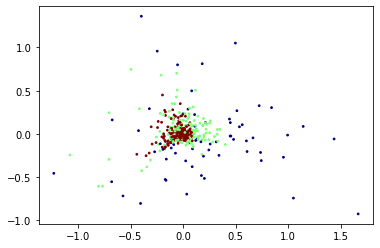

In [18]:
plt.scatter(reduced_data[:,1], reduced_data[:,2], c=Z, s=3, cmap='jet')

<BarContainer object of 1 artists>

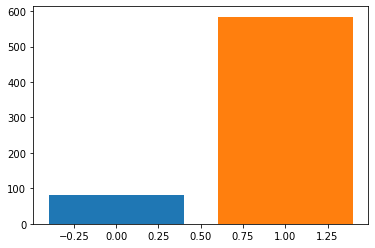

In [180]:
tot = np.size(SbC_kmeans_input,0)
msbc = len(maybe_SbCs)
plt.bar(0,msbc)
plt.bar(1,tot-msbc)

(array([ 64.,   0.,   0.,   0.,   0., 162.,   0.,   0.,   0., 439.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

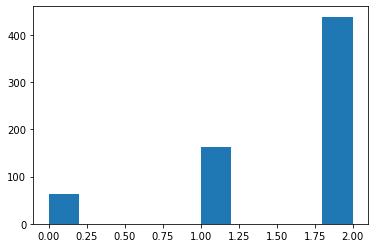

In [177]:
plt.hist(Z)

In [174]:
pop.data['km_label'] = Z

(-1.0, 1.0)

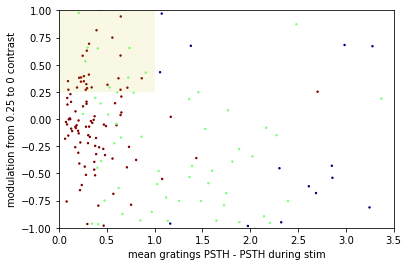

In [176]:
fig, ax = plt.subplots()
plt.scatter(pop.data['high_contrast_std'], pop.data['grat_psth_drop'], c=Z, s=2, cmap='jet')
plt.ylabel('modulation from 0.25 to 0 contrast')
plt.xlabel('mean gratings PSTH - PSTH during stim')
rect = patches.Rectangle((0, 0.25), 1, 0.75, linewidth=1, edgecolor='none', facecolor='y', alpha=0.1)
ax.add_patch(rect)
plt.xlim([0,3.5])
plt.ylim([-1,1])

In [164]:
i

621

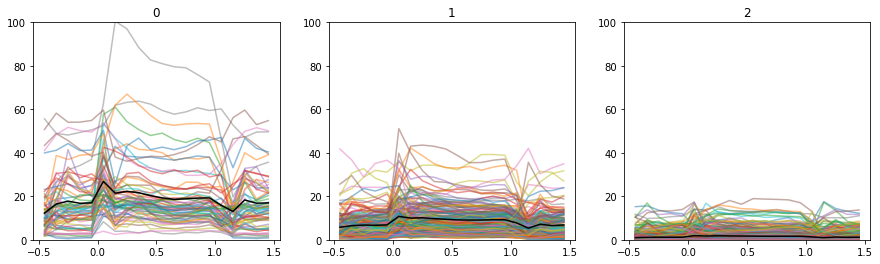

In [167]:
lower = -0.5; upper = 1.5; dt = 0.1
bins = np.arange(lower,upper+dt,dt)
grat_x = bins[0:-1]+dt/2
plt.subplots(1,3,figsize=(15,4))
for k in range(3):
    plt.subplot(1,3,k+1)
    for i, psth in pop.data['hf3_gratings_grating_psth'][pop.data['km_label']==k].iteritems():
        plt.plot(grat_x, psth, alpha=0.5)
    plt.plot(grat_x, np.mean(flatten_series(pop.data['hf3_gratings_grating_psth'][pop.data['km_label']==k]),0), 'k')
    plt.title(k)
    plt.ylim([0,100])

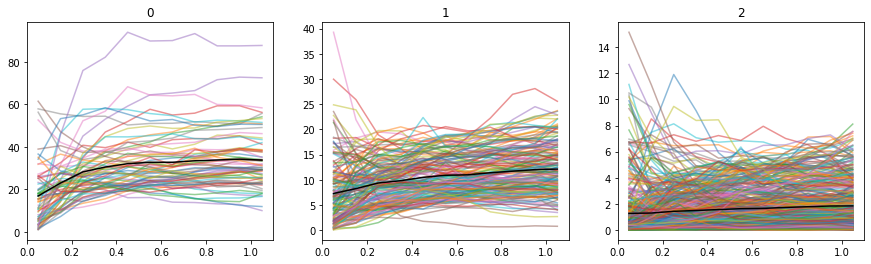

In [168]:
plt.subplots(1,3,figsize=(15,4))
for k in range(3):
    plt.subplot(1,3,k+1)
    for ind, row in pop.data[pop.data['km_label']==k].iterrows():
        plt.plot(row['hf1_wn_crf_cent'], row['hf1_wn_crf_tuning'], alpha=0.5)
    plt.plot(row['hf1_wn_crf_cent'], np.mean(flatten_series(pop.data['hf1_wn_crf_tuning'][pop.data['km_label']==k]),0),'k')
    plt.title(k)

In [ ]:
plt.figure()
# Z = agg.labels_
plt.scatter(reduced_data[:,0], reduced_data[:,1])#, c=Z, s=8, cmap='Set2')
# plt.tight_layout(); self.poppdf.savefig(); plt.close()

<ErrorbarContainer object of 3 artists>

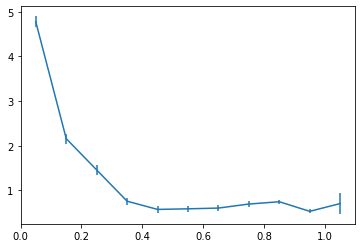

In [7]:
plt.errorbar(unit['hf1_wn_crf_cent'], unit['hf1_wn_crf_tuning'], yerr=unit['hf1_wn_crf_err'])

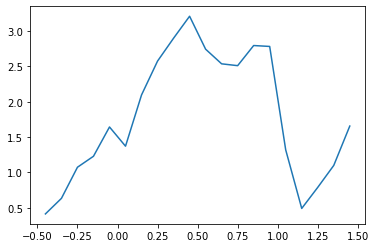

In [29]:
lower = -0.5; upper = 1.5; dt = 0.1
bins = np.arange(lower,upper+dt,dt)
psth = unit['hf3_gratings_grating_psth']
plt.plot(bins[0:-1]+ dt/2,psth)

In [30]:
len(psth)

20

In [ ]:
unit['grat_psth_drop']

In [ ]:
sbc_data = pop.data[pop.data['is_SbC']]
count = 1
plt.subplots(int(np.ceil(len(sbc_data)/8)),8,figsize=(20,15))
for ind, row in sbc_data.iterrows():
    plt.subplot(int(np.ceil(len(sbc_data)/8)),8,count)
    plt.title('unit='+str(ind)+' type='+str(row['movement_psth_type_simple']))
    leftavg = row['fm1_downsacc_avg_gaze_shift_dEye']
    rightavg = row['fm1_upsacc_avg_gaze_shift_dEye']
    plt.plot(pop.trange_x, leftavg, color='tab:red')
    plt.plot(pop.trange_x, rightavg, color='tab:blue')
    plt.xlim(-0.2,0.4)
    count += 1
for count in range(count, int(np.ceil(len(sbc_data)))):
    plt.subplot(int(np.ceil(len(sbc_data)/8)),8,count)
    plt.axis('off')
plt.tight_layout()

In [ ]:
np.mean(psth)

In [ ]:
np.shape(unit['hf1_wn_crf_tuning'])

In [ ]:
lower = -0.5; upper = 1.5; dt = 0.1
bins = np.arange(lower,upper+dt,dt)
grat_x = bins[0:-1]+ dt/2
for ind, row in pop.data.iterrows():
    if row['hf1_wn_crf_tuning'][0]<1:
        pop.data.at[ind, 'is_SbC'] = False
        continue
    high_contrast_std = np.std(row['hf1_wn_crf_tuning'][3:])
    pop.data.at[ind, 'high_contrast_std'] = high_contrast_std
    min_contrast = row['hf1_wn_crf_tuning'][0]
    mid_contrast = row['hf1_wn_crf_tuning'][3]
    max_contrast = row['hf1_wn_crf_tuning'][-1]
    min_min_mod = (min_contrast - mid_contrast) / (min_contrast + mid_contrast)
    min_max_mod = (min_contrast - max_contrast) / (min_contrast + max_contrast)
    pop.data.at[ind, 'SbC_min_mid_mod'] = min_min_mod
    pop.data.at[ind, 'SbC_min_max_mod'] = min_max_mod
    grat_psth_mean = np.mean(row['hf3_gratings_grating_psth'])
    grat_psth_during_stim = row['hf3_gratings_grating_psth'][(grat_x<1) * (grat_x>0)]
    pop.data.at[ind, 'grat_psth_drop'] = grat_psth_mean - np.mean(grat_psth_during_stim)
    pop.data.at[ind, 'is_SbC'] = (high_contrast_std<1 and min_min_mod>0.25)

In [ ]:
plt.hist(pop.data['grat_psth_drop'])

In [ ]:
plt.hist(pop.data['grat_psth_drop'][pop.data['is_SbC']], bins=20)

In [ ]:
pop.data['grat_psth_drop'][pop.data['is_SbC']]

In [ ]:
lower = -0.5; upper = 1.5; dt = 0.1
bins = np.arange(lower,upper+dt,dt)
grat_x = bins[0:-1]+dt/2
plt.subplots(1,2,figsize=(15,4))
plt.subplot(121)
for i, psth in pop.data['hf3_gratings_grating_psth'][pop.data['is_SbC']].iteritems():
    plt.plot(grat_x, psth, alpha=0.5)
plt.plot(grat_x, np.mean(flatten_series(pop.data['hf3_gratings_grating_psth'][pop.data['is_SbC']]),0), 'k')
plt.title('SbC')
plt.subplot(122)
for i, psth in pop.data['hf3_gratings_grating_psth'].iteritems():
    plt.plot(grat_x, psth, alpha=0.5)
plt.title('full population')
plt.plot(grat_x, np.mean(flatten_series(pop.data['hf3_gratings_grating_psth']),0), 'k')

In [ ]:
len(pop.data[pop.data['is_SbC']])

In [ ]:
len(pop.data)

In [ ]:
fig, ax = plt.subplots()
plt.plot(pop.data['high_contrast_std'], pop.data['SbC_min_mid_mod'], 'k.', markersize=1)
# for ind in possible_SbCs:
#     plt.plot(pop.data['high_contrast_std'].iloc[possible_SbCs], pop.data['SbC_min_mid_mod'].iloc[possible_SbCs], 'ro', markersize=3)
# plt.plot(unit['high_contrast_std'], unit['SbC_min_mid_mod'], 'g*', markersize=10)
plt.ylabel('modulation from 0.25 to 0 contrast')
plt.xlabel('std(high contrast values)')
rect = patches.Rectangle((0, 0.25), 1, 0.75, linewidth=1, edgecolor='none', facecolor='y', alpha=0.4)
ax.add_patch(rect)
plt.xlim([0,7])
plt.ylim([-1,1])

In [ ]:
plt.subplots(1,2,figsize=(15,4))
plt.subplot(1,2,1)
for ind, row in pop.data[pop.data['is_SbC']].iterrows():
    plt.errorbar(row['hf1_wn_crf_cent'], row['hf1_wn_crf_tuning'], yerr=row['hf1_wn_crf_err'], alpha=0.5)
plt.ylim([0,40])
plt.subplot(1,2,2)
for ind, row in pop.data[pop.data['is_SbC']].iterrows():
    plt.errorbar(row['hf1_wn_crf_cent'], row['hf1_wn_crf_tuning'], yerr=row['hf1_wn_crf_err'], alpha=0.5)
plt.ylim([0,8])